使用PTB数据集，但是仅使用其前1000个单词，因为在本节实现的RNNLM中，即便使用所有的训练数据，也得不出好的结果。

In [2]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

设定超参数

In [3]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTT的时间跨度大小
lr = 0.1
max_epoch = 100

读入训练数据（缩小了数据集）

**这里的vocab_size 一定是1000个单词的种类数**

**因为单词和id的统计转换是按顺序进行的，而1000个单词也是按顺序进行的**

In [9]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
# print(corpus)
vocab_size = int(max(corpus) + 1)
print(vocab_size)

418


输入值 和 输出的监督标签应该偏移一个值，因为是预测下一个位置

In [11]:
xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(data_size)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

999
corpus size: 1000, vocabulary size: 418


学习用的参数

In [12]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []  # perplexity 困惑度

生成模型

In [13]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

计算读入mini-batch的各笔样本数据的开始位置

In [14]:
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

当读入语料库的位置超过语料库大小时，为了回到语料库的开头处，将当前位置除以语料库大小后的余数作为索引使用。

In [15]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 获取mini-batch
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 计算梯度，更新参数
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 各个epoch的困惑度评价
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'% (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| epoch 1 | perplexity 366.01
| epoch 2 | perplexity 248.55
| epoch 3 | perplexity 222.09
| epoch 4 | perplexity 215.86
| epoch 5 | perplexity 204.99
| epoch 6 | perplexity 201.19
| epoch 7 | perplexity 197.31
| epoch 8 | perplexity 196.14
| epoch 9 | perplexity 190.75
| epoch 10 | perplexity 191.97
| epoch 11 | perplexity 187.92
| epoch 12 | perplexity 191.20
| epoch 13 | perplexity 189.12
| epoch 14 | perplexity 190.22
| epoch 15 | perplexity 188.17
| epoch 16 | perplexity 185.94
| epoch 17 | perplexity 183.51
| epoch 18 | perplexity 180.15
| epoch 19 | perplexity 182.91
| epoch 20 | perplexity 182.22
| epoch 21 | perplexity 183.52
| epoch 22 | perplexity 175.78
| epoch 23 | perplexity 172.94
| epoch 24 | perplexity 174.32
| epoch 25 | perplexity 173.04
| epoch 26 | perplexity 172.96
| epoch 27 | perplexity 169.28
| epoch 28 | perplexity 164.24
| epoch 29 | perplexity 162.97
| epoch 30 | perplexity 159.26
| epoch 31 | perplexity 160.57
| epoch 32 | perplexity 153.19
| epoch 33 | perp

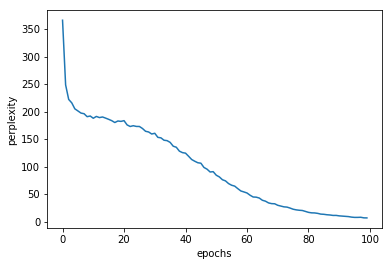

In [16]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

### 5.5.4 RNNLM的Trainer类

见trainer的RnnlmTrainer